In [43]:
# 所有内容基于下面的文章
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/  关于xgboost的调参数
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/  关于xgb的调参
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [44]:
# read csv
# 如果在read_csv时出现UnicodeDecodeError，需要查看文件的编码，可以使用：
# vim Train.csv 然后  :set fileencoding  查看编码
# :set fileencoding=utf-8 转换编码
train = pd.read_csv('../data/hackathon/Train.csv', encoding='latin1')
target = 'Disbursed'
IDcol = 'ID'
train.shape

(87020, 26)

In [45]:
train.columns

Index(['ID', 'Gender', 'City', 'Monthly_Income', 'DOB', 'Lead_Creation_Date',
       'Loan_Amount_Applied', 'Loan_Tenure_Applied', 'Existing_EMI',
       'Employer_Name', 'Salary_Account', 'Mobile_Verified', 'Var5', 'Var1',
       'Loan_Amount_Submitted', 'Loan_Tenure_Submitted', 'Interest_Rate',
       'Processing_Fee', 'EMI_Loan_Submitted', 'Filled_Form', 'Device_Type',
       'Var2', 'Source', 'Var4', 'LoggedIn', 'Disbursed'],
      dtype='object')

In [46]:
# 探索特征
train.dtypes

ID                        object
Gender                    object
City                      object
Monthly_Income             int64
DOB                       object
Lead_Creation_Date        object
Loan_Amount_Applied      float64
Loan_Tenure_Applied      float64
Existing_EMI             float64
Employer_Name             object
Salary_Account            object
Mobile_Verified           object
Var5                       int64
Var1                      object
Loan_Amount_Submitted    float64
Loan_Tenure_Submitted    float64
Interest_Rate            float64
Processing_Fee           float64
EMI_Loan_Submitted       float64
Filled_Form               object
Device_Type               object
Var2                      object
Source                    object
Var4                       int64
LoggedIn                   int64
Disbursed                  int64
dtype: object

In [47]:
len(set(train['City']))

698

In [48]:
train['City'].isnull().value_counts()

False    86017
True      1003
Name: City, dtype: int64

In [49]:
# City variable dropped because of too many categories
del train['City']
train.shape

(87020, 25)

In [50]:
# DOB converted to Age | DOB dropped, we drop DOB
del train['DOB']

In [51]:
train.shape

(87020, 24)

In [52]:
# EMI_Loan_Submitted_Missing created which is 1 
# if EMI_Loan_Submitted was missing else 0 | Original variable EMI_Loan_Submitted dropped
train['EMI_Loan_Submitted'].isnull().value_counts()

True     59294
False    27726
Name: EMI_Loan_Submitted, dtype: int64

In [53]:
59294 / 87020   #  EMI_Loan_Submitted 缺失值过高>0.25, drop or convert to EMI_Loan_Submitted_Missing then drop

0.6813835899793151

In [54]:
train['EMI_Loan_Submitted_Missing'] = train['EMI_Loan_Submitted'].isnull().map(lambda x: int(x))
del train['EMI_Loan_Submitted']

In [55]:
# EmployerName dropped because of too many categories
len(set(train['Employer_Name'])) / train.shape[0]

0.500666513445185

In [56]:
# Employer_Name 分类过多，不好用，drop
del train['Employer_Name']

In [57]:
# Existing_EMI imputed with 0 (median) since only 111 values were missing
train['Existing_EMI'].describe()

count    8.694900e+04
mean     3.696228e+03
std      3.981021e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.500000e+03
max      1.000000e+07
Name: Existing_EMI, dtype: float64

In [63]:
null_cnt = train['Existing_EMI'].isnull().value_counts()
print(null_cnt)

train['Existing_EMI'] = train['Existing_EMI'].fillna(0)

False    86949
True        71
Name: Existing_EMI, dtype: int64


In [69]:
# Interest_Rate_Missing created which is 1 if Interest_Rate 
# was missing else 0 | Original variable Interest_Rate dropped
# 缺失值高
print(train['Interest_Rate'].isnull().value_counts() / len(train['Interest_Rate']))
print('Convert to Interest_Rate_Missing')
train['Interest_Rate_Missing'] = train['Interest_Rate'].isnull().map(lambda x: int(x))
del train['Interest_Rate']

True     0.681384
False    0.318616
Name: Interest_Rate, dtype: float64
Convert to Interest_Rate_Missing


In [73]:
# Lead_Creation_Date dropped because made little intuitive impact on outcome
del train['Lead_Creation_Date']

In [75]:
# Loan_Amount_Applied, Loan_Tenure_Applied imputed with median values
print(train['Loan_Amount_Applied'].isnull().value_counts())
train['Loan_Amount_Applied'].describe()

False    86949
True        71
Name: Loan_Amount_Applied, dtype: int64


count    8.694900e+04
mean     2.302507e+05
std      3.542068e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+05
75%      3.000000e+05
max      1.000000e+07
Name: Loan_Amount_Applied, dtype: float64

In [78]:
train['Loan_Amount_Applied'] = train['Loan_Amount_Applied'].fillna(train['Loan_Amount_Applied'].median())
# train['Loan_Amount_Applied'].median()

In [79]:
# Loan_Amount_Submitted_Missing created which is 1 if 
# Loan_Amount_Submitted was missing else 0 | Original variable Loan_Amount_Submitted dropped
train['Loan_Amount_Submitted_Missing'] = train['Loan_Amount_Submitted'].isnull().map(lambda x: int(x))
del train['Loan_Amount_Submitted']

In [80]:
train['Loan_Tenure_Applied'] = train['Loan_Tenure_Applied'].fillna(train['Loan_Tenure_Applied'].median())

In [81]:
# Loan_Tenure_Submitted_Missing created which is 1 if 
# Loan_Tenure_Submitted was missing else 0 | Original variable Loan_Tenure_Submitted dropped
train['Loan_Tenure_Submitted_Missing'] = train['Loan_Tenure_Submitted'].isnull().map(lambda x: int(x))
del train['Loan_Tenure_Submitted']

In [88]:
# LoggedIn, Salary_Account dropped
# del train['LoggedIn']
train['LoggedIn'].value_counts() / train['LoggedIn'].shape[0]   # 0 值过高 >0.75

0    0.97065
1    0.02935
Name: LoggedIn, dtype: float64

In [89]:
del train['LoggedIn']

In [92]:
# train['Salary_Account'].value_counts()  
del train['Salary_Account']

In [94]:
# Processing_Fee_Missing created which is 1 
# if Processing_Fee was missing else 0 | Original variable Processing_Fee dropped
train['Processing_Fee'].isnull().value_counts() / train['Processing_Fee'].shape[0]

True     0.6849
False    0.3151
Name: Processing_Fee, dtype: float64

In [95]:
train['Processing_Fee_Missing'] = train['Processing_Fee'].isnull().map(lambda x: int(x))
del train['Processing_Fee']

In [96]:
# Source – top 2 kept as is and all others combined into different category
train.columns

Index(['ID', 'Gender', 'Monthly_Income', 'Loan_Amount_Applied',
       'Loan_Tenure_Applied', 'Existing_EMI', 'Mobile_Verified', 'Var5',
       'Var1', 'Filled_Form', 'Device_Type', 'Var2', 'Source', 'Var4',
       'Disbursed', 'EMI_Loan_Submitted_Missing', 'Interest_Rate_Missing',
       'Loan_Amount_Submitted_Missing', 'Loan_Tenure_Submitted_Missing',
       'Processing_Fee_Missing'],
      dtype='object')

In [114]:
top2 = list(train['Source'].value_counts().head(2).index)
top2
to_other = train['Source'].apply(lambda x, t2: 'Other' if x not in t2 else x, args=(top2, ))
train['Source'] = to_other

In [116]:
# Numerical and One-Hot-Coding performed
train.dtypes

ID                                object
Gender                            object
Monthly_Income                     int64
Loan_Amount_Applied              float64
Loan_Tenure_Applied              float64
Existing_EMI                     float64
Mobile_Verified                   object
Var5                               int64
Var1                              object
Filled_Form                       object
Device_Type                       object
Var2                              object
Source                            object
Var4                               int64
Disbursed                          int64
EMI_Loan_Submitted_Missing         int64
Interest_Rate_Missing              int64
Loan_Amount_Submitted_Missing      int64
Loan_Tenure_Submitted_Missing      int64
Processing_Fee_Missing             int64
dtype: object

In [122]:
train['Var2'].value_counts()

B    37280
G    33032
C    14210
E     1315
D      634
F      544
A        5
Name: Var2, dtype: int64

In [124]:
train_df = pd.get_dummies(train)

In [125]:
### 以上都是清洗的测试过程，最终结果见Hackathon 3.x Data Preparation.ipynb
### 下面是调优过程
# Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

train_df = pd.read_csv('train_modified.csv')

In [126]:
train_df.head()

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,0.0,ID000002C20,300000.0,5.0,20000,1,0,37,1,...,0,0,0,0,1,1,0,1,0,0
1,0.0,0.0,ID000004E40,200000.0,2.0,35000,3,13,30,0,...,0,0,0,0,1,0,1,1,0,0
2,0.0,0.0,ID000007H20,600000.0,4.0,22500,1,0,34,1,...,0,0,0,0,0,0,1,0,0,1
3,0.0,0.0,ID000008I30,1000000.0,5.0,35000,3,10,28,1,...,0,0,0,0,0,0,1,0,0,1
4,0.0,25000.0,ID000009J40,500000.0,2.0,100000,3,17,31,1,...,0,0,0,0,0,0,1,0,0,1


In [127]:
test_df = pd.read_csv('test_modified.csv')
test_df.head()

,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,Age,EMI_Loan_Submitted_Missing,Interest_Rate_Missing,...,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6,Mobile_Verified_0,Mobile_Verified_1,Source_0,Source_1,Source_2
0,0.0,ID000026A10,100000.0,3.0,21500,3,3,28,0,0,...,0,0,0,0,0,0,1,1,0,0
1,0.0,ID000054C40,0.0,0.0,42000,5,8,35,0,0,...,1,0,0,0,0,0,1,0,1,0
2,0.0,ID000066O10,300000.0,2.0,10000,1,0,26,1,1,...,0,0,0,0,0,1,0,0,1,0
3,0.0,ID000110G00,0.0,0.0,14650,1,0,24,1,1,...,1,0,0,0,0,1,0,0,1,0
4,5000.0,ID000113J30,100000.0,1.0,23400,1,0,28,1,1,...,0,0,0,0,0,0,1,0,0,1


In [150]:
# Before proceeding further, lets define a function which will help us create XGBoost models and 
# perform cross-validation. 
# The best part is that you can take this function as it is and use it later for your own models.
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds) # , show_progress=False
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    # Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    booster = alg._Booster
    feat_imp = pd.Series(booster.get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
# Choose all predictors except target & IDcols
predictors = [x for x in train_df.columns if x not in [target, IDcol]]


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.896723


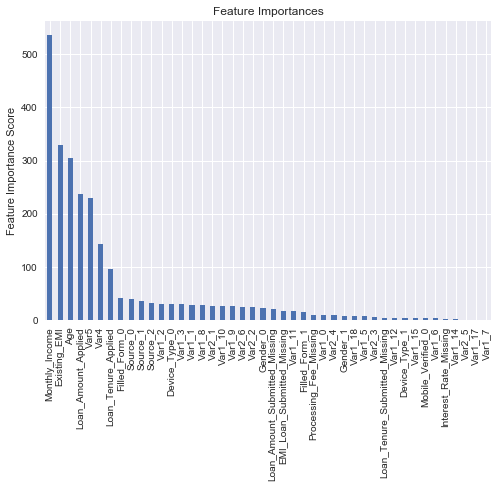

In [152]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
)
modelfit(xgb1, train_df, predictors)

In [154]:
# Step2 Tune max_depth and min_child_weight
param_test1 = {
    'max_depth': list(range(3,10,2)),
    'min_child_weight': list(range(1,6,2))
}
gsearch1 = GridSearchCV(
    estimator=XGBClassifier(learning_rate =0.1, 
                            n_estimators=140, 
                            max_depth=5,
                            min_child_weight=1, 
                            gamma=0, 
                            subsample=0.8, 
                            colsample_bytree=0.8,
                            objective= 'binary:logistic', 
                            nthread=4, 
                            scale_pos_weight=1, 
                            seed=27),
    param_grid=param_test1, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5
)

gsearch1.fit(train_df[predictors],train_df[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83690, std: 0.00821, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83730, std: 0.00858, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83713, std: 0.00847, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84051, std: 0.00748, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84112, std: 0.00595, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84123, std: 0.00619, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83772, std: 0.00518, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83672, std: 0.00579, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83658, std: 0.00355, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.82690, std: 0.00622, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.82909, std: 0.00560, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83203, std: 0.00708, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 5

In [156]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(
    estimator=XGBClassifier( 
        learning_rate=0.1, 
        n_estimators=140, 
        max_depth=5,
        min_child_weight=2, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1,
        seed=27), 
    param_grid=param_test2, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5)
gsearch2.fit(train_df[predictors], train_df[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.84031, std: 0.00658, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.84061, std: 0.00700, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.84125, std: 0.00723, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.83988, std: 0.00612, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.84123, std: 0.00619, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83995, std: 0.00591, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.83905, std: 0.00635, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.83904, std: 0.00656, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.83844, std: 0.00682, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 4, 'min_child_weight': 6},
 0.8412491517082822)

In [157]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(
    estimator=XGBClassifier( 
        learning_rate=0.1, 
        n_estimators=140, 
        max_depth=4,
        min_child_weight=2, 
        gamma=0, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective= 'binary:logistic', 
        nthread=4, 
        scale_pos_weight=1,
        seed=27), 
    param_grid=param_test2b, 
    scoring='roc_auc',
    n_jobs=4,
    iid=False, 
    cv=5
)
gsearch2b.fit(train_df[predictors],train_df[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=2, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.875742


([mean: 0.84125, std: 0.00723, params: {'min_child_weight': 6},
  mean: 0.84028, std: 0.00710, params: {'min_child_weight': 8},
  mean: 0.83920, std: 0.00674, params: {'min_child_weight': 10},
  mean: 0.83996, std: 0.00729, params: {'min_child_weight': 12}],
 {'min_child_weight': 6},
 0.8412491517082822)

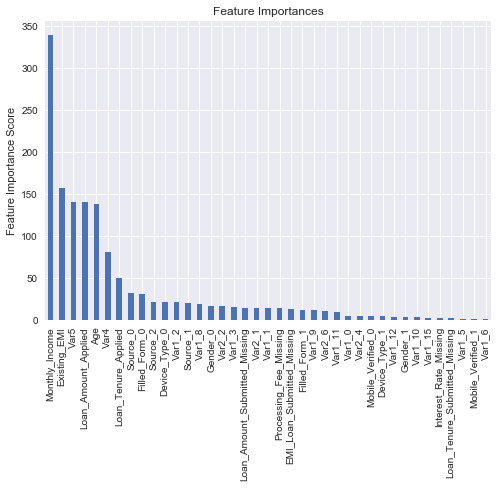

In [158]:
modelfit(gsearch2b.best_estimator_, train_df, predictors)
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_